# Predicting Patent Industries by Text Analysis

by Constantin Knoll, Christopher Mosch, Rohan Thavarajah

## Table of Contents

[1. Overview](#1.)
* [1.1 Motivation](#1.1)
* [1.2 Objectives](#1.2)

[2. Prediction and Analysis](#2.)
* [2.1 Google Patent Data](#2.1)
* [2.2 Industry Definition Data](#2.2)
* [2.3 Text Processing and Industry Mapping](#2.3)
* [2.4 Accuracy via USPTO Baseline](#2.4)

[3. Results](#3.) 
* [3.1 Discussion](#3.1)
* [3.2 Opportunities for Refinement](#3.2)

<a id='1.'></a>
## 1. Overview

<a id='1.1'></a>
### 1.1 Motivation

Patent data is an extremely pure metric of innovative activity. It is also incredibly rich with fields like inventor geography, grant date, citations, technology field and assignee. The key challenge is, as powerful as these fields are, they are unsuitable for connecting patent data to other datasets.

Some fields are messy such assignee; firms are manually input and so are accompanied by the attendant ills of name variation and the difficulty of pinning down a single entity. Other fields, like technology field, while powerful tools for exploration, are unique to the patent domain.

Economic datasets like GDP (US Census Bureau), Productivity (Bureau of Labor Statistics) and Research and Development expenditure (National Science Foundation) all have two things in common:
(1) they are metrics strongly tethered to the welfare of society and so tend to yield very meaningful insights.
(2) they all produce data with an industry dimension.

Our objective is to add a North American Industrical Classification (NAICS 2002) dimension to patent data to connect it to a vast ecosystem of economic datasets. We pursue this goal by applying LDA to patent abstracts.

<a id='1.2'></a>
### 1.2 Background

Prior efforts to add an industry dimension to patent data tend to fall in one of two buckets:

**Approach 1 (assignee-driven)**: Researchers take the company that owns the patent, look it up in a financial database and retrieve its industry. However, as well as being plagued by the ills of messy assignee names, this means that analysis begins by biasing sample selection towards firms that appear in databases i.e. researchers who employ this approach must excise patents owned by all but the largest firms.

**Approach 2 (technology field-driven)**: Researchers establish a concordance between technology fields and industries via manual inspection. Perhaps the best known example of this is a study conducted by the USPTO in 2012 (http://www.uspto.gov/web/offices/ac/ido/oeip/taf/naics/doc/naics_info.htm). 

However, there are two key disadvantages with this approach.
- First and foremost, the high level of manual intervention means that the cost of iterating on the concordance approach is prohibitive.
US Technology and NAICS Industry classification systems are both in a state of flux. The USPTO report classifies industries by NAICS 2002. But the system has been updated twice since then (to the NAICS 2007 and then NAICS 2012). These concordance tables becomes fossils at a fast rate.

    By using text analysis and automating the patent-to-industry mapping we introduce a system that can flexibly be updated depending on what industry code prevails at the time.


- Second, as the USPTO caution in their report:
        "USPTO staff are not classifying U.S. patents directly into NAICS industry categories. The distribution of patent counts by NAICS industry category, as displayed in this report, is determined using a very general concordance between two substantially different classification systems, the U.S. Patent Classification System and the North American Industry Classification System. As such, the patent counts associated with each of the different NAICS categories should be viewed with caution and may serve only as a very general indicator of the patenting activity in those categories."
    
   By applying text analysis to patent abstracts we hope to provide, if not a silver bullet, an approach that can incorporated into an ensemble to improve classification.
   
   In fact we use the USPTO's predictions to furnish a baseline upon which we assess our performance. This guides some early decisions on our part:
   - we map patents to 3-dig NAICS 2002 in the manufacturing sector only.
   - we focus on the years 2002-2003.

  However, our self-same text-based approach could equally be applied to a different industrial classification and band of years.

<a id='2.'></a>
## 2. Prediction and Analysis

The diagram below illustrates our workflow. In short, we split up the tasks into four notebooks, each indicated by one of the colored boxes below.

In [1]:
from IPython.display import Image, display

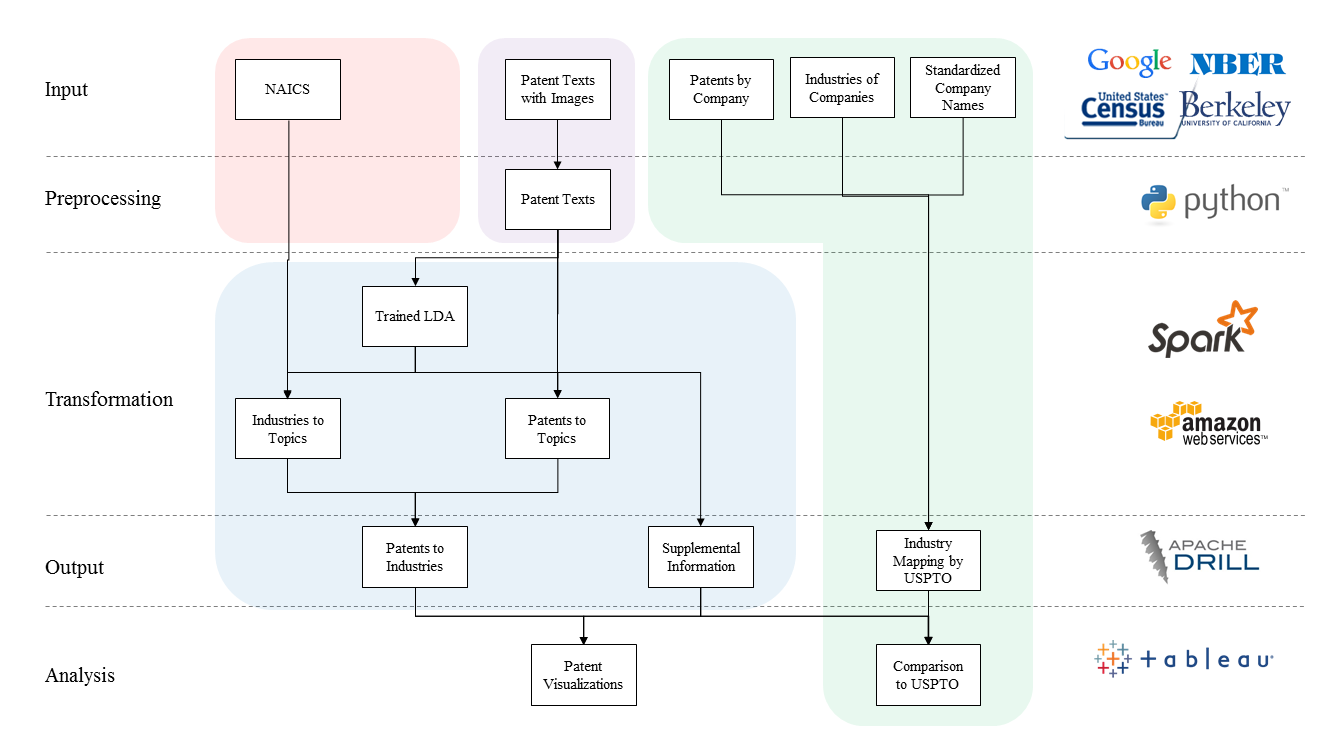

In [3]:
display(Image(filename='Data/Images/Workflow.png', embed=True, width=900))

<img style="width: 900px" src="Data/Images/Workflow.png"/>

<a id='2.1'></a>
### 2.1 Google Patent Data

The purpose of this notebook is to automate the downloading, unpacking, and subsequent uploading (to S3) of patent data available on Google. We scrape patent files with supplements and images from the url found in the User Guide. The data is grouped by weeks, ranging from 2001 to 2015. The years 2011- are compressed in .tar format, while the earlier ones are compressed as .zip. Thus, the code accounts for these options by including the python libraries ZipFile and TarFile. 
The code found in Compact Version (which we used mainly) downloads a single week of patent data, extracts, uploads and deletes it before repeating the process with another week. This is optimized to work on very small storage space such as an SSD on our local machine.
Each week of patent data contains several folders with different content. For the purposes of our project, we are only interested in the abstracts, which are found in the .xml files of the patent application body. Thus, we need to get rid of all supplements (as defined by the user below) and all images that aren't conducive to data analysis. This is reflected in the main Code, where the tree of the downloaded data is searched for all unwanted folders, which are deleted.
It is important to realize that the "deleted" files are typically dropped into the recycle bin of the local machine, and thus the purpose of running the space-optimized code is compromised. Therefore we advise the user to us an automated recycle bin clean-up program. It should be set to clean every 10-15 minutes, which is the average time it takes to complete the cycle for one week of patent data.
Since we get rid of most of the data found in the patent files, the convoluted folder structure that remains is thrown out and replaced by a three-tiered one: 1) Root 2) Year 3) Week.
The uploading to S3 is controlled by the boto3 library, which takes care of most of the uploading automatically.

<img  width=600 src="Data/Images/2.1_S3.png"/>

<a id='2.2'></a>
### 2.2 Industry Definition Data

**Goal** - scrape the Census Bureau's webpage for NAICS definitions and output a list of dictionaries. Each dictionary will have a high-level parent naics, and the nouns in all the definitions of its lower-level children

**NAICS overview** - The NAICS 2002 is a hierarchical classifiction of industry. Each 2 digit naics is comprised of a set of 3 digit naics, each 3 digit naics of 4 digit naics and so on. The Census Bureau lays out their website to reflect this. If you are interested in finding the definition of a 6 digit naics, you must first select its parent and drill down to it. Therefore we have 4 steps

- Step 1 - step through every tier of Census Bureau definitions and compile a list of urls to terminal definition pages
- Step 2 - from each page fetch title, conceptual definition and items 
- Step 3 - set the definition of parents = the sum of definitions of descendents
- Step 4 - construct a noun dictionary for each 3-digit naics

**Output signature** - We wish to construct a list of dictionaries. Each dictionary will reflect a 3 digit NAICS and have the following signature:
<img  width=350 src="Data/Images/2.2_naics_get_nouns_output_signature.png"/>


<a id='2.3'></a>
### 2.3 Text Processing and Industry Mapping

This notebook predicts for each patent the industry to which the patent most likely belongs. This is done in three steps. First, we transform the raw patent text data into the form that is required to perform Latent Dirichlet Allocation (LDA). In particular, we obtain the abstract from each patent and the nouns contained in the former. We focus on the abstracts because they are the most expressive part of the patent and thus most relevant for our purpose. Secondly, we extract topics from the patent data using the LDA implementation in gensim. In the third step, we map the LDA topics to industries and thereby obtain an industry prediction for each patent. The first part of the mapping is to input the nouns of the industry definitions into LDA. Thereby, we use the resulting relation of industries to topics to create a sparse matrix of the industry-topic relation. For each patent, we then multiply the sparse vector representing the relation of the patent to all topics with the industry-topic matrix and thereby obtain for each industry the probability that a patent belongs to this industry. This is illustrated in the diagram below. Finally, this data and additional data such as the inventor company is put into a data frame, which is then saved to S3.

<img  width=800 src="Data/Images/2.3_Patent-Industry_Mapping.png"/>

<a id='2.4'></a>
### 2.4 Accuracy via USPTO Baseline

The purpose of this notebook is to compare our results to a “Silver Standard” in order to gauge our performance. We begin with a discussion of why some divergence from the standard is desirable. After merging our predictions with those of the USPTO, we find that our performance is better in some industries than others. We perform best on textiles, paper, metal and computer and electronics. Our most costly failure is in chemicals and we point the reader to the further refinements section for our ideas on how to resolve this.

<a id='3.'></a>
## 3. Results

<a id='3.1'></a>
### 3.1 Discussion

The dashboards that we created on the basis of our industry predictions for patents can be found on https://public.tableau.com/views/Chronan_public/top_patentees_by_ind?:embed=y&:display_count=yes&:showTabs=y.

**Top Patentees by Industry**

An insightful way to look at the clustered patents is to view the most active patentees in each industry. Filtering on "334 - Computer and Electronics", we see that the three largest innovators in this industry are Canon, IBM and Hitachi. On the whole, our prediction suggests that American and Japanese companies dominate the computer and electronics industry, which is what we would expect to see.

<img  width=900 src="Data/Images/2.4_viz1.png"/>


<br>
**Company Profile**

On the micro level, we can also zoom in on a specific company and analyze the industries this firm patents in. For example, consider Hitachi Ltd. Hitachi Ltd, owing to being an organisation with both chemical and metals arms, has peaks for metal manufacturing and chemical manufacturing. This profile can then be compared to other companies. In this way, our analysis enables a new way to compare the similarity of companies based on their research acitivities.

<img  width=900 src="Data/Images/2.4_viz2.png"/>
<br>

**Innovation Landscape**

On the macro level, our predictions can be used to visualize the development of patent activity both across locations and time. In the example below, we are able to observe the concentration of innovation at innovation hubs such as San Francisco, Austin, and New York.

<img  width=900 src="Data/Images/2.4_viz3.png"/>

<a id='3.2'></a>
### 3.2 Opportunities for Refinement

**Refinement of Inputs**
- Apply permid.org API to standardize assignee names and render filtering by assignee name less cumbersome.
- Search for more definitions for each NAICS. Initially we had tried to use the intersection between industry definitions and topic keywords to construct the topic -> industry mapping. However, because industry definitions have relatively little content, this led to the intersections being prohibitively small.
- We have focused on 2002-2003 because these are years in which we have a USPTO baseline for comparison. We can readily scale up years of interest to the past 20 years. The main impediment is that the schemas of the patent .xml input files change over time so we need to alter the functions for scraping the .xmls in some years (we have already done this for 2005 but have not implemented it).


**Refinement of Processes**
- Incorporate citations field. For instance we could append to each abstract the abstract of first order citations before running LDA. This would draw the topic of each patent towards the mean topic of its immediate citations.
- Because we map topics to industries, we do not pay as hefty a cost in interpretability if we ask LDA to generate many topics. Our results are based on running LDA with 40 topics and we have saved output which utilizes 60 and 80 respectively. It would be interesting to see how performance evolves as a function of number of topics.
- At the moment we choose patent industry by whichever has the highest weight. We should introduce cutoff thresholds for weights that are either too small or too similar to the second highest weight. 